# <font color="dodgerblue">Binarization cleaning and mathematical morphology</font>

As a reminder, here are the main steps leading us to our goal about **baby-foot ball tracking** <font size='2'>&#x26BD;</font>:

* <font size='2'>1️⃣</font> Detecting the <font size='2'>⚽</font> ball
* <font size='2'>2️⃣</font> Detecting the <font size='2'>🥅</font> goal cages
* <font size='2'>3️⃣</font> Counting goals when the ball reaches the goal cages

In the previous notebook, we managed to get a descent **[image segmentation](https://en.wikipedia.org/wiki/Image_segmentation)** assuring that the <font size='2'>⚽</font>`ball` is <font size='2'>👁‍🗨</font> visible (or almost) on each frame of our video.

We learned about:
* the importance of the preprocessing task,
* convolution and image filtering,
* updating our image processing pipeline to get a cleaner segmentation result.

Our previous validated pipeline is as bellow:

<font size='4'>✅</font> **image_processing_<span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span>**
* <font color="dodgerblue">**Preprocessing**</font>
    - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> RGB image to grayscale image transformation
    - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> Grayscale image to ubyte image so we get values in <font color='maroon'>[0, 255]</font>
    - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Difference of gaussians to get rid of shadows
* <font color="dodgerblue">**Segmentation**</font>
    - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Binarization using an otsu automated threshold

At the end, we got a <font size='3'>😎</font> cool result on our baby-football video where the frames were cleaned and the <font size='2'>⚽</font> ball (almost) <font size='2'>👁‍🗨</font> visible on each of them.

The next step is to discriminate the <font size='2'>⚽</font> ball from the other objects and artifacts in order to detect and localize it later.

In this notebook, we continue our <font size='3'>🚀</font> journey in the segmentation land.

### <font color="dodgerblue">Useful imports</font>

In [16]:
# imports managing paths
from glob import glob
import os.path

# import about matrix
import numpy as np

# imports about managing images and videos
import skimage as ski
import skimage.io as io

# import for displaying image and videos
import matplotlib.pyplot as plt

# other imports
%run functions/np_hist.ipynb # np_hist(grayscale_image) --> histogram array
%run functions/bin_threshold.ipynb # bin_threshold(grayscale_img, threshold) --> binary_image
%run functions/get_video_frames_from.ipynb # loading a  and copying the frames in a list
%run functions/play_video.ipynb # play_video(video_frames, interval, show_axis='on') --> plt_vid
%run functions/treat_video.ipynb # treat_video(frames, threshold, our_func)-->treated_frames array
%run functions/image_processing_v2.ipynb # image_processing_v2(image, threshold)-->binary_image result

# <font color='dodgerblue'>1. Naive cleaning approach of a binary segmentation</font>

In the previous notebook, we managed to get a first valuable [image segmentation](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Image_segmentation&ved=2ahUKEwjEmY7-lLqHAxXGfKQEHd_XAz8QFnoECBYQAQ&usg=AOvVaw2L4Ili5rq-sxwyCn1Mi3_q) process where the <font size='2'>⚽</font> ball segment is <font size='2'>👁‍🗨</font> visible on each frame (or almost) but we have also some <font size='2'>❌</font> unwanted objects and artifacts that we would like to clean.

<img src="videos/result_video_processing_v2.webp"/>

In order to track the <font size='2'>⚽</font> ball's position correctly later, the ultimate segmentation result that we wish to have would be as illustrated by the right image of the figure bellow.

<table>
    <tr>
        <td><b>Color image (RGB image)</b></td>
        <td><b>Grayscale image (grayscale image)</b></td>        
        <td><b>Whished Segmented image (binary image)</b></td>
    </tr>
    <tr>
        <td><img src="figs/eg_image_1.png" width=500/></td>
        <td><img src="figs/eg_gray_1.png" width=500/></td>
        <td><img src="figs/eg_seg_image_1.png" width=500/></td>
    </tr>
</table>

Such result is not easy to have on realistic applications like what we would like to do with our baby-football <font size='2'>⚽</font> ball detection and tracking.

## <font color='dodgerblue'>1.1. Dealing with non moving objects</font>

We will see a little bit in this notebook that strong tools as [Mathematical Morphology](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Mathematical_morphology&ved=2ahUKEwily7PdlrqHAxU8BfsDHVCEBE0QFnoECB0QAQ&usg=AOvVaw084Mtmv_ZOiAizPWrZhJd_) exists to helps us to clean our segmentation intermediate result.

But let's keep in mind that as we wish to apply our image processing pipeline on each frame of a video, we would want something with less time cost.
This factor for sure impacting the choice that we have to do in terms of tools to use.
Indeed, some super tools and methods would perhaps give us a great clean result but at the cost of some times computation.
We will have really to find the good balance between the performance and the time cost.

At it is right now, let's use some advantages that our specific application could offer us.

In our application, we prepared the scene carefully in order to make it as easier as possible for us to learn an apply some basics of image processing so we can reach our final <font size='3'>🎯</font> goal.

Yes, we have to prepare everything carefully.

* We have fixed a camera above our scene in order to only see the baby-football table. We want to avoid all the artifacts that some objects all around of the baby-football table could represent.
* The <font size='2'>⚽</font> ball is white

Now that we know that, we can understand that there are two kinds of objects in our scene:

* **moving objects** as the <font size='2'>⚽</font> ball and the players
* **non moving objects** such as the <font size='2'>🥅</font> goal cages, the field, the markings)

Let's use those non moving objects to our advantages.

As a grayscale image is represented by a matrix we can apply on it everything that we can do on a matrix such as mathematical operations, slicing,...


By considering a frame not having the <font size='2'>⚽</font> ball represented on it, we can apply the image processing pipeline that we implemented until now (i.e. image_processing_v2(...)) on it an get a segmentation result of static non moving objects.

<img src='figs/no-ball-image.png'/>

We can then think that we can substract those non moving objects from our intermediate segmentation result so at least we will just have the moving objects.

<img src='figs/remove-non-moving-objs.png'/>

### <font color='dodgerblue'>1.1.1 Getting the non moving objects</font>

Let's apply our image_processing_v2(...) on the image bellow that we took from the video that not contain the <font size='2'>⚽</font> ball on it.

<img src='images/bg_image.png'/>

The image to consider for this tasks must be from the video since we want to treat a particuliar scene.
Not doing so may bring us the risk to add some <font size='2'>❌</font> unwanted artifacts that may will bring us more difficulties for the next steps.

<div style="padding : 20px; background-color:#E6E6FA;">
    
##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to get a descent binarization of an image not having the <font size='2'>⚽</font> ball on it.</font> <font size='5'>🔨</font>**

Use our implemented function image_processing_v2(...) on our no_ball_image.

**<font size='2'>✨</font> <font color='teal'>Path of the file to use:</font>**

- 'images/nb_image.png'

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. Loading the image located at 'images/bg_image.png' that does not contain a <font size='2'>⚽</font> ball
2. Applying on the image no_ball_image our function image_processing_v2(...) with an Otsu automated threshold
3. Showing the result

**<font size='2'>✨</font> <font color='teal'>Functions to use:</font>**

- io.imread(image_path)
- [image_processing_v2(image, threshold)](functions/image_processing_v2.html)

**<font size='2'>✨</font> <font color='teal'>The output result should be as follows.</font>**

<img src='figs/no-ball-image.png'/>

</div>

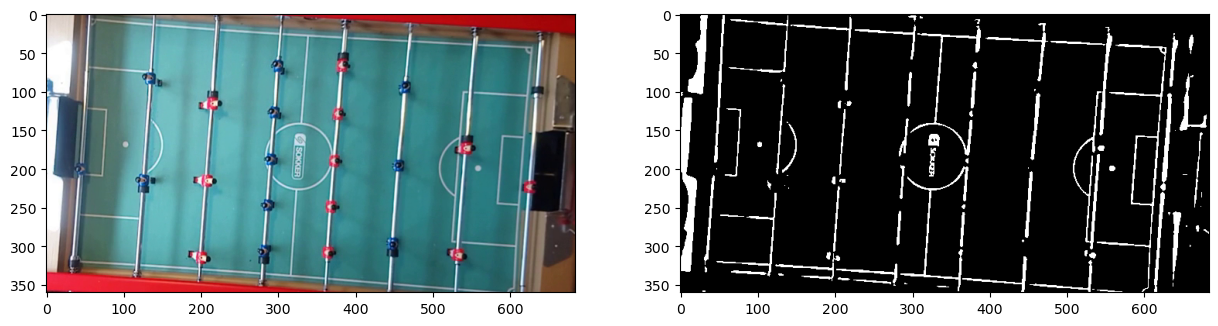

In [10]:
# TODO -- get a descent binarization of an image not having the ball on it.

%matplotlib inline
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray

# 1. Loading the image located at 'images/bg_image.png' that does not contain a ball
no_ball_image = io.imread('images/bg_image.png')

# 2. Applying on the image no_ball_image our function image_processing_v2(...) with an Otsu automated threshold
threshold = 'otsu'

bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 3. Showing the result
fig = plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(no_ball_image, cmap='gray')
plt.subplot(122)
plt.imshow(bin_no_ball, cmap='gray')
plt.show()

In [11]:
plt.close()

### <font color='dodgerblue'>1.1.2. Removing the non moving objects from our previous results</font>

Now that we have our static objects (but also artifacts) depicted in a binary segmentation result, we have now to substract them to a binary segmentation result of the image the we want to treat.

The idea of substration is simple, but before doing it, let's have in mind that we can apply basic operations such as `+`, `-`, `*` and `/` on int or float matrices but this is not the case of a binary matrix where the values are bool.
We have to use binary operations on such matrices.

Here is a small memo of binary operations:

| operator | logical operation | assembly operation (form) | Commentary   |
|-----------|-------------------|-------------------------------|---------------|
| `&`       | logical and       |shape intersection             |               |
| `\|`       | logical or        |shape union                   |               |
| `~`       | logical not       |shape complement               |               |
| `^`       | logical xor       |shape difference               | `A^B` == `A&(~B) \| B&(~A)` |

Before doing an operation, we should then check the data type `dtype` of our matrices.

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to remove non moving objects and arfifacts from binary images.  </font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- bin_no_ball

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. Selecting two images
2. Applying image_processing_v2(...) on each image with an otsu treshold
3. Cleaning the binary results by applying a substraction
4. Showing the result

**<font size='2'>✨</font> <font color='teal'>The output result should be as follows.</font>**

<img src='figs/remove-non-moving-objs.png'/>

</div>

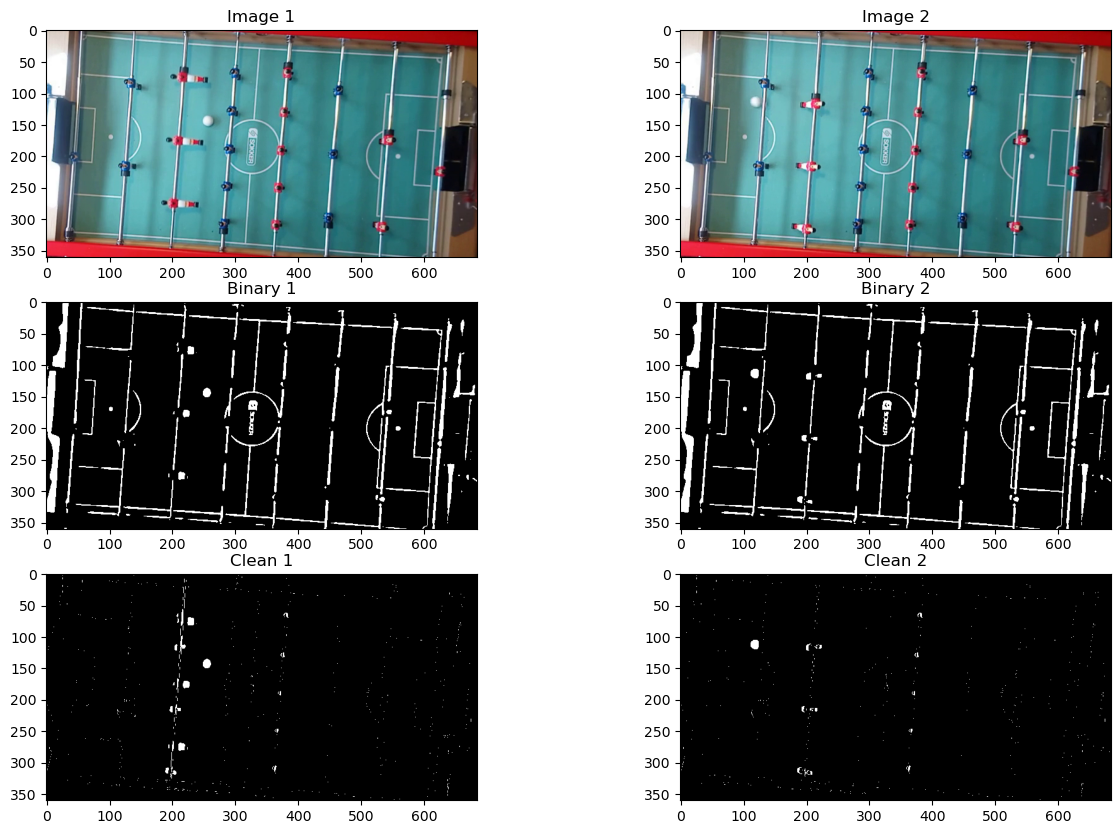

In [19]:
# TODO -- Removing non moving objects and arfifacts from binary images.

%matplotlib inline

# 1. Selecting two images
video_frames = get_video_frames_from('videos/video_1_360.mp4')
image1 = video_frames[50]
image2 = video_frames[100]

# 2. Applying image_processing_v2(...) on each image with an otsu treshold
th = 'otsu'
bin_res1 = image_processing_v2(image1, th)
bin_res2 = image_processing_v2(image2, th)

# 3. Cleaning the binary results by applying a substraction
clean1 = bin_res1 ^ bin_no_ball
clean2 = bin_res2 ^ bin_no_ball

# 4. Showing the result
fig = plt.figure(figsize=(15,10))
fig.canvas.header_visible = False
plt.subplot(321)
plt.title("Image 1")

# Preparing the display for image1
plt.imshow(image1)

plt.subplot(322)
plt.title("Image 2")

# Preparing the display for image2
plt.imshow(image2)

plt.subplot(323)
plt.title("Binary 1")

# Preparing the display for bin_res1
plt.imshow(bin_res1, cmap='gray')

plt.subplot(324)
plt.title("Binary 2")

# Preparing the display for bin_res2
plt.imshow(bin_res2, cmap='gray')

plt.subplot(325)
plt.title("Clean 1")

# Preparing the display for clean1
plt.imshow(clean1, cmap='gray')

plt.subplot(326)
plt.title("Clean 2")

# Preparing the display for clean2
plt.imshow(clean2, cmap='gray')

plt.show()

In [20]:
plt.close()

After the cleaning result, we notice that the <font size='2'>⚽</font> ball is still <font size='2'>👁‍🗨</font> visible (which is very very important) while the other <font size='2'>❌</font> unwanted objects and some amount of artifacts have been erased from our results.

## <font color='dodgerblue'>1.2. Applying the binarization cleaning on a video</font>

We can now update our image_processing_v2(...) into image_processing_v3(...) by adding this step of cleaning in our segmentation process.

### <font color="dodgerblue">1.2.1. Image processing function v3</font>

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to pdate the image_processing_v2(...) function into image_processing_v3(...) by adding what we have learned to remove the non moving objects and artifacts</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. Defining the function image_processing_v3(...)
2. Getting a segmentation result on the image by using the function image_processing_v2(...)
3. Returning a binary image without the moving objects and artifacts
4. Loading the images: 2 images of the video and 1 without the <font size='2'>⚽</font> ball
5. Getting a segmentation intermediate result from the binary which does not have the <font size='2'>⚽</font> ball by using image_processing_v2(...) and by considering an 'otsu' automated threshold
6. Applying the image_processing_v3(...) on image1 and image2
7. Displaying the result

**<font size='2'>✨</font> <font color='teal'>Prototype of the function to implement:</font>**

image_processing_v3(image, threshold, binary_no_ball):

**<font size='2'>✨</font> <font color='teal'>Function to use:</font>**

- image_processing_v2(...)

**<font size='2'>✨</font> <font color='teal'>The output result should be as follows.</font>**

<img src='figs/image_processing_v3_res.png'/>

</div>


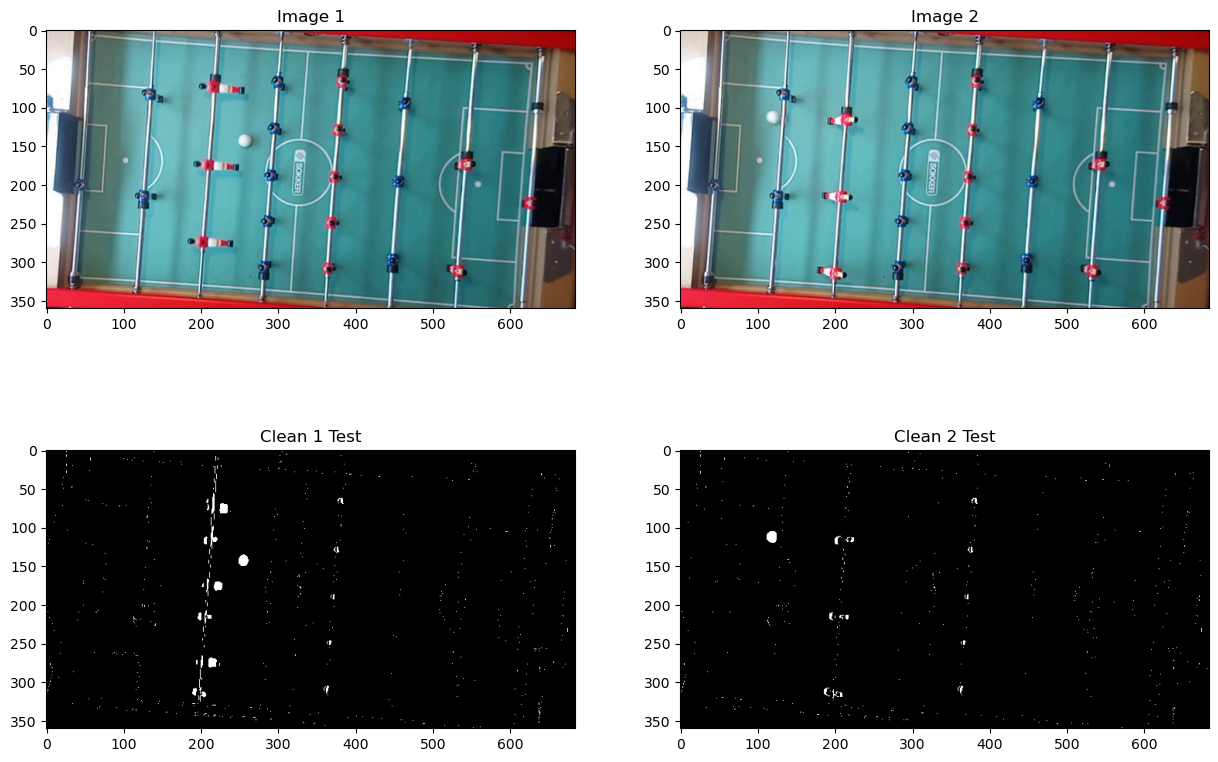

In [41]:
# TODO -- Update the image_processing_v2(...) function into image_processing_v3(...)
# by adding what we have learned to remove the non moving objects and artifacts

# 1. Defining the function image_processing_v3(...)
def image_processing_v3(image, threshold, binary_no_ball=bin_no_ball):

    # 2. Getting a segmentation result on the image by using the function image_processing_v2(...)
    bin_res = image_processing_v2(image, threshold)

    # 3. Returning a binary image without the moving objects and artifacts
    return bin_res ^ binary_no_ball

%matplotlib inline

# 4. Loading the images: 2 images of the video and 1 without the ball
image1 = video_frames[50]
image2 = video_frames[100]
no_ball_image = io.imread('images/bg_image.png')

# 5. Getting a segmentation intermediate result from the binary which does not have the ball
# by using image_processing_v2(...) and by considering an 'otsu' automated threshold
th = 'otsu'
bin_no_ball = image_processing_v2(no_ball_image, th)

# 6. Applying the image_processing_v3(...) on image1 and image2
clean1_test = image_processing_v3(image1, th, bin_no_ball)
clean2_test = image_processing_v3(image2, th, bin_no_ball)

# 7. Displayin the results
fig = plt.figure(figsize=(15,10))
fig.canvas.header_visible = False
plt.subplot(221)
plt.title("Image 1")

# Preparing the display for image1
plt.imshow(image1, cmap='gray')

plt.subplot(222)
plt.title("Image 2")

# Preparing the display for image2
plt.imshow(image2, cmap='gray')

plt.subplot(223)
plt.title("Clean 1 Test")

# Preparing the display for clean1_test
plt.imshow(clean1_test, cmap='gray')

plt.subplot(224)
plt.title("Clean 2 Test")

# Preparing the display for clean2
plt.imshow(clean2_test, cmap='gray')

plt.show()

In [42]:
plt.close('all')

### <font color="dodgerblue">1.2.2. Video treatment and vizualization</font>

Let's apply the new version of our image processing pipeline on each frames of our video.

#### <font color="dodgerblue">Image processing on each video frame</font>

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to apply our image processing function on each frame of a video.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>✅</font> Loading and getting the video frames and the image <font color='maroon'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
2. <font size='2'>⭕</font> Specifying <font color='red'>'otsu'</font> as threshold
3. <font size='2'>⭕</font> Applying the <font size='3'>⚙</font> [image_processing_v2(...)](functions/image_processing_v2.html) on the image <font color='red'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
4. <font size='2'>⭕</font> Calling the function <font size='3'>⚙</font> [treat_video(...)](functions/treat_video.html) to apply our <font size='3'>⚙</font> <font color='maroon'>image_processing_v3(...)</font> function on each frames of <font color='maroon'>video_frames</font>
5. <font size='2'>✅</font> Showing the length of the list containing the binary images result

**<font size='2'>✨</font> <font color='teal'>Functions to consider:</font>**

Here are the simplified prototypes of the functions to consider.

<font size='3'>⚙</font> **[treat_video(video_frames, threshold, our_func)](functions/treat_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - threshold: grayscale value in <font color='maroon'>[0, 255]</font> to use for the binarization process.
    - our_func: a function that will be called for each frame of the video. This function is meant to gather a set of image processing tasks.
- **Return**
    - <font color='maroon'>treated_frames</font>: list of images corresponding to the results

<font size='3'>⚙</font> **[image_processing_v2(image, threshold)](functions/image_processing_v2.html)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

<font size='3'>⚙</font> **image_processing_v3(image, threshold, binary_no_ball=bin_no_ball)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
    - binary_no_ball: binary image containing the segments of the non moving
    objects and artifacts. By default, we will use what is in bin_no_ball
    which is a global variable that should contain a result of the call
    of the function image_processing_v2(...) on an image not containing the <font size='2'>⚽</font> ball
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

**<font size='2'>✨</font> <font color='teal'>The output result should be as follows:</font>**

```
165
```

<br/> This result corresponds to the number of treated images.

</div>

In [43]:
# TODO -- Apply a binarization process on each frame of a video

# 1. Loading and getting the video frames and the image which does not have the ball on it
video_frames = get_video_frames_from('videos/video_1_360.mp4')
no_ball_image = io.imread('images/bg_image.png')

# 2. Specifying an 'otsu' as threshold
threshold = 'otsu'

# 3. Applying the image_processing_v2(...) on the image no_ball_image which does not have the ball on it 
bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 4. Calling the function 'treat_video(...)' to apply a binarization image processing v3 on each frames of 'video_frames'
video_result = treat_video(video_frames, threshold, image_processing_v3)

# 5. Showing the length of the array containing the binary images result
len(video_result)

165

#### <font color="dodgerblue">Display of the video binarization</font>

For now, let's show and enjoy the result. <font size='5'>📺</font>

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to play the video binarized result.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- <font color="maroon">video_result</font>

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>⭕</font> Choosing an interval (in ms) between each frame display
2. <font size='2'>⭕</font> Displaying the video <font color='maroon'>video_result</font> by calling the function [play_video(...)](functions/play_video.html)

**<font size='2'>✨</font> <font color='teal'>Function to call:</font>**

<font size='3'>⚙</font> **[play_video(video_frames, interval, show_axis='on')](functions/play_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - interval: time in millisecond (ms) between two frames.
    - show_axis: <font color="maroon">'on'</font> to show axis values, <font color="maroon">'off'</font> to hide them. Notice that this is not mandatory and it is set to <font color="maroon">'on'</font> by default.

**<font size='2'>✨</font> <font color='teal'>Output result:</font>**

You should see your resulting video displayed.

<font size='5'>⚠</font> Feel free to change the value of the <font color="maroon">interval</font> and experiment the changes and perhaps slow motions. <font size='5'>🐌</font>

</div>

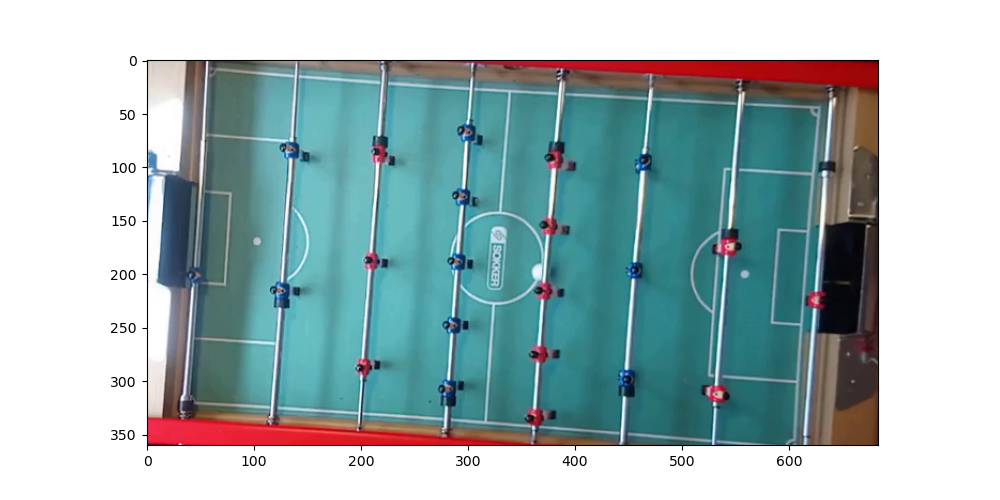

In [45]:
# TODO -- Play the result of the video binarization

%matplotlib widget

# 1. Choosing an interval (in ms) between each frame display
interval = 5

# 2. Displaying the video 'video_result' by calling the function 'play_video(...)'
play_video(video_frames, interval, show_axis='on')


In [51]:
plt.close()

Great! We now have a cleaner segmentation result where the <font size='2'>⚽</font> ball is still <font size='2'>👁‍🗨</font> visible on all (or almost) frames while having less <font size='2'>❌</font> unwanted objects and some artifacts.

This result really is a big step forward but we can go further and try to clean it again.

### <font color="dodgerblue">1.2.3. Time cost of image_processing_v3(...)</font> <font size='5'>⌛ 💵</font>

What about the time cost now?

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to get the time cost of our video treatment.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- <font color="maroon">video_frames</font>

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>⭕</font> Use the magic command [%%timeit](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) to get the time cost of the whole code cell
2. <font size='2'>⭕</font> Specifying <font color='red'>'otsu'</font> as threshold
3. <font size='2'>⭕</font> Applying the <font size='3'>⚙</font> [image_processing_v2(...)](functions/image_processing_v2.html) on the image <font color='red'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
4. <font size='2'>⭕</font> Calling the function <font size='2'>⚙</font> [treat_video(...)](functions/treat_video.html) to apply our <font size='3'>⚙</font> <font color='maroon'>image_processing_v3(...)</font> function on each frames of <font color='maroon'>video_frames</font>

**<font size='2'>✨</font> <font color='teal'>Function to call:</font>**

Here is the prototype of the function to use.

<font size='3'>⚙</font> **[treat_video(video_frames, threshold, our_func)](functions/treat_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - threshold: grayscale value in <font color='maroon'>[0, 255]</font> to use for the binarization process.
    - our_func: a function that will be called for each frame of the video. This function is meant to gather a set of image processing tasks.
- **Return**
    - <font color='maroon'>treated_frames</font> a list of images corresponding to the results

<font size='3'>⚙</font> **[image_processing_v2(image, threshold)](functions/image_processing_v2.html)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

**<font size='2'>✨</font> <font color='teal'>The output result should be similar (but not totally) as follows:</font>**

```
9.51 s ± 637 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

<br/> What can we say about this result?

</div>

In [50]:
%%timeit 
# 1. Use the magic command %%timeit to get the time cost of the whole code cell

# 2. Specifying an 'otsu' as threshold
threshold = 'otsu'

# 3. Applying the image_processing_v2(...) on the image no_ball_image which does not have the ball on it
bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 4. Calling the function treat_video(...) to apply our image_processing_v3(...) function
# on each frames of video_frames
video_result = treat_video(video_frames, threshold, image_processing_v3)

4.13 s ± 63.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The time cost may be more and more expensive so we will have to be really careful for the choice of methods and tools to use for the next steps.

A strategy of optimization could be interesting for later.

# <font color='dodgerblue'>2. Mathematical morphology for binary images</font>

In order to reach do a descent clean binary image, the [mathematical morphology](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Mathematical_morphology&ved=2ahUKEwily7PdlrqHAxU8BfsDHVCEBE0QFnoECB0QAQ&usg=AOvVaw084Mtmv_ZOiAizPWrZhJd_) section of the image processing reasearches proposes some interesting methods.

[Mathematical morphology](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Mathematical_morphology&ved=2ahUKEwily7PdlrqHAxU8BfsDHVCEBE0QFnoECB0QAQ&usg=AOvVaw084Mtmv_ZOiAizPWrZhJd_) is a branch of image processing that was developed in the 1960s by Georges Matheron and Jean Serra, two French researchers at the École des Mines de Paris. Relatively simple to understand from a conceptual point of view, this discipline makes it possible, with a little practice, to set up powerful non-linear filtering and shape detection/recognition algorithms.

Although it applies very well to grayscale images (see the session), and very poorly for color images, the [mathematical morphology](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Mathematical_morphology&ved=2ahUKEwily7PdlrqHAxU8BfsDHVCEBE0QFnoECB0QAQ&usg=AOvVaw084Mtmv_ZOiAizPWrZhJd_) is understood first by manipulating binary images.

**Important!**

By convention, it is considered that everything that is in white in a binary image is an object, and the black corresponds to the background of the image.

## <font color='dodgerblue'>2.1. Erosion and dilation</font>

The two basic operations of mathematical morphology are erosion and dilation. In both cases, they take as a parameter (in addition to the image to be processed) a [structuring element](https://en.wikipedia.org/wiki/Structuring_element) (generally abbreviated SE or strel, for [structuring element](https://en.wikipedia.org/wiki/Structuring_element)).

What is a [structuring element](https://en.wikipedia.org/wiki/Structuring_element)?

- It's an image with a very simple shape: a square, a cross, a circle, a line, etc.
- Each [structuring element](https://en.wikipedia.org/wiki/Structuring_element) depends on at least one parameter defining its size: the radius for a circle, the length for a line, etc.
- This [structuring element](https://en.wikipedia.org/wiki/Structuring_element) is used to define a neighborhood mask around each pixel (you will understand the illustrations below).

In [53]:
# Let's define some shortcuts to a bunch of structuring element shapes
# There're all functions (width --> np.array)
from skimage.morphology import disk as se_disk, diamond as se_diamond, square as se_square
def se_cross(w):
    cross3 = np.array([[0,1,0],[1,1,1],[0,1,0]]).astype(bool)
    return ski.transform.resize(cross3,(w,w))
def se_vert_l(l):
    return np.ones((l,1))
def se_horz_l(l):
    return np.ones((1,l))
def se_diag_l(l):
    return np.eye(l)

# A list with all our fonctions to generate structuring elements
MM_strel = [('disk', se_disk), ('diamond', se_diamond),('square', se_square), ('cross', se_cross),
            ('horz line', se_horz_l),('vert line', se_vert_l),('diag line', se_diag_l)]

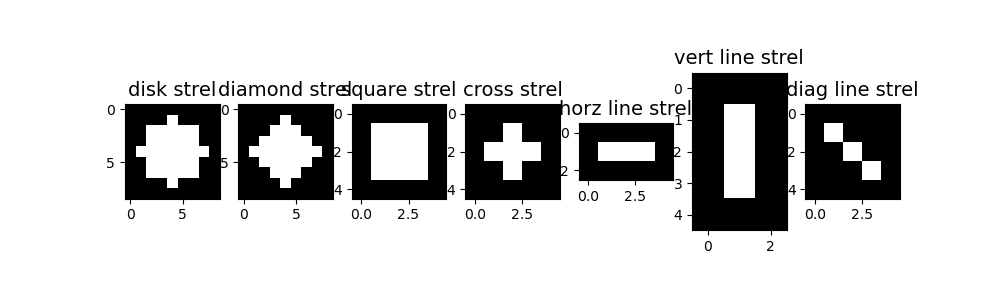

In [55]:
fig = plt.figure(figsize=(10,3))
fig.canvas.header_visible = False
for ii, (name, se_function) in enumerate(MM_strel):
    plt.subplot(1,len(MM_strel),ii+1)
    strel = se_function(3)
    plt.imshow(np.pad(strel,1),cmap='gray')
    plt.title(f"{name} strel",fontsize=14)
plt.show()

In [56]:
plt.close()

### <font color='dodgerblue'>2.1.1 Erosion of a binary image by a given structuring element</font>

Although there is a mathematical definition of erosion, there is no need to go into a somewhat cumbersome formalism to understand what happens: a drawing is better than a formula in this particular case. Let's look at the binary image below. 

<img src="figs/mm/Illustration_morpho.png" width=400>

Calculating the erosion of this binary image by a [structuring element](https://en.wikipedia.org/wiki/Structuring_element) of a given form, for each pixel, to ask the following question:

**Does the [structuring element](https://en.wikipedia.org/wiki/Structuring_element) (centered on the current pixel) overflow the background of the image when I place it on the pixel - where I am?**

- If yes $\rightarrow$ The pixel becomes white.
- If not $\rightarrow$ The pixel stays black.

The idea is similar to what we saw in the image convolution where we had to slide the kernel by placing its origin every single pixel of the image.
In [mathematical morphology](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Mathematical_morphology&ved=2ahUKEwily7PdlrqHAxU8BfsDHVCEBE0QFnoECB0QAQ&usg=AOvVaw084Mtmv_ZOiAizPWrZhJd_), the strucutral element has bo be slided also as it is done in convolution while considering its origin.

For example, the result of the erosion of the previous image by a square-shaped [structuring element](https://en.wikipedia.org/wiki/Structuring_element) $3 \times 3$
would look like this 

<img src="figs/mm/Illustration_erosion.png" width=400>

The erosion operation nibbles the objects with a shape defined by the [structuring element](https://en.wikipedia.org/wiki/Structuring_element).

More formally, the erosion affects the current pixel the minimum value of the neighborhood defined by the [structuring element](https://en.wikipedia.org/wiki/Structuring_element).

### <font color='dodgerblue'>2.1.2. Dilation of a binary image by a given structuring element¶</font>

Dilation is the reverse operation of erosion: instead of nibbling on objects, it causes them to enlarge in the shape defined by the [structuring element](https://en.wikipedia.org/wiki/Structuring_element). Calculating the dilation of a binary image by a [structuring element](https://en.wikipedia.org/wiki/Structuring_element) of a given form is this time to ask the following question for each pixel:

**Does the [structuring element](https://en.wikipedia.org/wiki/Structuring_element) intersect the object when I place it on the pixel - where I am?**

- If yes $\rightarrow$ The pixel becomes.
- If not $\rightarrow$ The pixel stays.

For example, the result of the expansion of the previous image by the same square-shaped [structuring element](https://en.wikipedia.org/wiki/Structuring_element) would look like this.

<img src="figs/mm/Illustration_dilatation.png" width=400>

This time, the gray pixels correspond to the pixels of the background 'black' which are converted into pixels of the object 'white' following the expansion operation (therefore they would be 'white' in the dilated image).

The expansion operation causes the objects to swell with a shape defined by the [structuring element](https://en.wikipedia.org/wiki/Structuring_element).

More formally, the expansion affects the current pixel the maximum value of the neighborhood defined by the [structuring element](https://en.wikipedia.org/wiki/Structuring_element).

Mathematically, the erosion of an image $I$ by a [structuring element](https://en.wikipedia.org/wiki/Structuring_element) $s$ is noted $\varepsilon(I,s)$, or $\varepsilon_s(I)$, or $I \ominus s$.

For dilaration, use $\delta(I,s)$, $\delta_s(I)$, or $I \oplus s$

See [here](https://fr.wikipedia.org/wiki/Morphologie_math%C3%A9matique#Cas_ensembliste) ou [there](https://en.wikipedia.org/wiki/Mathematical_morphology#Binary_morphology) for the mathematical formulation of erosion and expansion operations.

In [57]:
# Let's define some shortcuts for erosion and dilation functions
from skimage.morphology import erosion
from skimage.morphology import dilation

MM_ope = [('erosion', erosion),('dilation', dilation)]

Good to know (or not): we tend, by habit, to import functions `skimage.morphology.erosion` and `skimage.morphology.dilation` of `scikit-image`, but these are actually the functions implemented in `scipy.ndimage` which work in the background.

**Using the interactive widget below, test the erosion and dilation operations on the previously charged binary image, varying the size and nature of the [structuring element](https://en.wikipedia.org/wiki/Structuring_element).**

In [58]:
from ipywidgets import interact
import ipywidgets as widgets

%matplotlib widget

img = clean1

@interact(op=widgets.RadioButtons(options=MM_ope,description='operation'),
         strel=widgets.Dropdown(options=MM_strel,description='strel'),
         param=widgets.IntSlider(value=3,min=3,max=15,step=1,description='size',continuous_update=False))
def basic_morpho(op,strel,param):
    for i in range(10):
        plt.close()
    strel_ = strel(param)
    strel_fig = np.zeros(np.array(strel_.shape)+2)
    strel_fig[1:-1,1:-1] = strel_
    img_op = op(img,strel_)
    fig = plt.figure(figsize=(2,2))
    fig.canvas.header_visible = False
    plt.imshow(strel_fig,cmap='gray')
    plt.title('Structuring element (size %d)'%param,fontsize=8)
    plt.tight_layout()
    plt.show()
    fig = plt.figure(figsize=(10,3))
    fig.canvas.header_visible = False
    plt.subplot(121)
    plt.imshow(img,cmap='gray')
    plt.title('Binary image',fontsize=14)
    plt.subplot(122)
    plt.imshow(img_op,cmap='gray')
    plt.title('Resulting operation',fontsize=14)
    plt.tight_layout()
    plt.show()

interactive(children=(RadioButtons(description='operation', options=(('erosion', <function erosion at 0x7f809f…

In [ ]:
plt.close('all')

### <font color='dodgerblue'>2.1.3. Morphological gradient</font>

The erosion $\varepsilon_s(I)$ of $I$ corresponds to a version of $I$ where the objects have been eroded (therefore less extensive) of the shape $s$. The difference $I - \varepsilon_s(I)$ shows therefore the pixels which have been snacked on the edges of the objects of $I$: these are therefore the inner contours of the objects of $I$. The same reasoning applies to $\delta_s(I) - I$, which shows the external contours of the objects of $I$. The difference $\delta_s(I) - \varepsilon_s(I)$ therefore contains the internal and external contours of the objects. These 3 gradients are called morphological gradients since their shape depends on the shape of the [structuring element](https://en.wikipedia.org/wiki/Structuring_element).

In [59]:
def inner_grad(img,strel):
    return img ^ erosion(img,strel) # image - erosion (- == binary XOR)

def outer_grad(img,strel):
    return dilation(img,strel) ^ img # dilation - image

def thick_grad(img,strel):
    return dilation(img,strel) ^ erosion(img,strel) # dilation - erosion
    # could also be: `inner_grad(img,strel) | outer_grad(img,strel)` : "|" == binary OR

It should be noted that we can use `^` for the difference between 2 binary images as in the code of `inner_grad()` and `outer_grad()` because we know that the first image used is a super-assembly of the second, so we never have the case $B&(~A)$.

**Using the interactive widget below, observe the 3 morphological gradients of the previous image by varying the shape of the [structuring element](https://en.wikipedia.org/wiki/Structuring_element). Do some [structuring elements](https://en.wikipedia.org/wiki/Structuring_element) seem more appropriate to you than others?**

In [60]:
@interact(strel=widgets.Dropdown(options=MM_strel,description='strel',))
def morpho_gradient(strel):
    for i in range(10):
        plt.close()
    strel_ = strel(3)
    fig = plt.figure(figsize=(10,6))
    plt.subplot(221)
    plt.imshow(img,cmap='gray')
    plt.title('Our binary input',fontsize=14)
    plt.subplot(222)
    plt.imshow(inner_grad(img,strel_),cmap='gray')
    plt.title('Inner gradient',fontsize=14)
    plt.subplot(223)
    plt.imshow(outer_grad(img,strel_),cmap='gray')
    plt.title('Outer gradient',fontsize=14)
    plt.subplot(224)
    plt.imshow(thick_grad(img,strel_),cmap='gray')
    plt.title('Thick gradient',fontsize=14)
    fig.canvas.header_visible = False
    plt.tight_layout()
    plt.show()

interactive(children=(Dropdown(description='strel', options=(('disk', <function disk at 0x7f80a1a8c7c0>), ('di…

In [61]:
plt.close('all')

## <font color='dodgerblue'>2.2. Opening, closing and top-hat transform</font>

Even if erosion and expansion operations are the basis of the majority of morphological operations, we do not go very far with just them 2. On the other hand, by judiciously combining them, it is possible to define much more advanced operations and particularly adapted for problems of recognition/identification of shapes in images, of non-uniform lighting correction, etc.

The two most basic combinations that can be formed with erosion and expansion are to follow:

* first erosion, then dilation, or
* first dilation, then erosion.

In the first case, when the [structuring element](https://en.wikipedia.org/wiki/Structuring_element) used is the same, it is called an eopening: $\gamma_s(I) = \delta_s\big( \varepsilon_s(I)\big)$. In the second case, the following is referred to as closure: $\phi_s(I) = \varepsilon_s\big(\delta_s(I)\big)$.

$\downarrow$ opening $\gamma_s(I) = \delta_s\big( \varepsilon_s(I)\big)$ | $\downarrow$ closure $\phi_s(I) = \varepsilon_s\big(\delta_s(I)\big)$
- | -
<img src="figs/mm/Illustration_ouverture.png" width=400> | <img src="figs/mm/Illustration_fermeture.png" width=400>

The opening, since it begins with erosion, will tend to eliminate fine objects (i.e., of smaller morphology than the [structuring element](https://en.wikipedia.org/wiki/Structuring_element) element used) and disconnect the objects connected by small structures. On the other hand, the closure will tend to plug the holes and connect the nearby objects (with a smaller distance than the [structuring element](https://en.wikipedia.org/wiki/Structuring_element)). The two images above illustrate the operations of opening and closing by a square $3 \times 3$. In the case of the opening, the shaded pixels are those which are converted from white to black, and therefore eliminated by the opening. For closing, this is obviously the reverse: the shaded pixels are those of the bottom that are connected to the object via the closure.

To recover these pixels/zones precisely, the top-hat transforms are used:

* white top-hat $T^⬜_s(I) = I - \gamma_s(I)$ corresponds to the difference between the image and its opening $\rightarrow$ these are the pixels deleted from the object by the opening
* The black top-hat $T^⬛_s(I) = \phi_s(I) - I$ corresponds to the difference between the closing of the image and the image $\rightarrow$ these are the pixels reconnected to the object by closing

$\downarrow$ White top_hat $T^⬜_s(I) = I - \gamma_s(I)$ | $\downarrow$ Black top_hat $T^⬛_s(I) = \phi_s(I) - I$
- | -
<img src="figs/mm/Illustration_white_tophat.png" width=400> | <img src="figs/mm/Illustration_black_tophat.png" width=400>

In [62]:
from skimage.morphology import opening
from skimage.morphology import closing
from skimage.morphology import black_tophat
from skimage.morphology import white_tophat

MM_ope2 = [('opening', opening), ('closing', closing),
           ('black top-hat', black_tophat), ('white top-hat', white_tophat)]

**Using the interactive widget below, test the opening and closing operations, as well as the two top-hat transforms on the previously charged binary image, varying the size and nature of the [structuring element](https://en.wikipedia.org/wiki/Structuring_element).**

In [63]:
img1 = clean1
img2 = clean2 
@interact(op=widgets.RadioButtons(options=MM_ope2,description='operation'),
         strel=widgets.Dropdown(options=MM_strel,description='strel'),
         param=widgets.IntSlider(value=3,min=3,max=15,step=1,description='size',continuous_update=False))
def slightlymoreadvanced_morpho(op,strel,param):
    for i in range(10):
        plt.close()    
    strel_ = strel(param)
    strel_fig = np.zeros(np.array(strel_.shape)+2)
    strel_fig[1:-1,1:-1] = strel_
    img_op1 = op(img1,strel_)
    img_op2 = op(img2,strel_)
    fig = plt.figure(figsize=(2,2))
    fig.canvas.header_visible = False
    plt.imshow(strel_fig,cmap='gray')
    plt.title('Structuring element (size %d)'%param,fontsize=8)
    plt.tight_layout()
    plt.show()
    fig = plt.figure(figsize=(10,6))
    fig.canvas.header_visible = False
    plt.subplot(221)
    plt.imshow(img1,cmap='gray')
    plt.title('Binary image 1',fontsize=14)
    plt.subplot(222)
    plt.imshow(img_op1,cmap='gray')
    plt.title('Resulting operation 1',fontsize=14)
    plt.subplot(223)
    plt.imshow(img2,cmap='gray')
    plt.title('Binary image 2',fontsize=14)
    plt.subplot(224)
    plt.imshow(img_op2,cmap='gray')
    plt.title('Resulting operation 2',fontsize=14)
    plt.tight_layout()
    plt.show()

interactive(children=(RadioButtons(description='operation', options=(('opening', <function opening at 0x7f809f…

In [ ]:
plt.close('all')

## <font color='dodgerblue'>2.3. Morphological reconstruction</font>

Morphological reconstruction is another way of filtering the related components of an image, no longer by attribute, but by position. In practice, given an image of markers (also called seeds), the morphological reconstruction keeps in the image only the related components which contain one (or more) marker(s). For example, in the image below

<img src="figs/mm/Illustration_reconstruction_morphologique.png" width=800>

Reconstruction is an operation that is rarely used with binary images (even if you will probably have to use it for the following exercise). On the other hand, it is an important tool of grayscale morphology.

# <font color='dodgerblue'>3. Using mathematical morphology in our pipeline</font>

From what we have learned about [mathematical morphology](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://en.wikipedia.org/wiki/Mathematical_morphology&ved=2ahUKEwily7PdlrqHAxU8BfsDHVCEBE0QFnoECB0QAQ&usg=AOvVaw084Mtmv_ZOiAizPWrZhJd_), there are many interesting operators and tons of combinations of them to help us to do a better clean of our baby-footbal segmentation results.

In this part, we will try some of those operators and their combinations in order to make the <font size='2'>⚽</font> ball (or a small part of it) <font size='2'>👁‍🗨</font> visible while removing <font size='2'>❌</font> unwanted objects and artifacts as much as we can.

## <font color='dodgerblue'>3.1. image_processing_v3_1(...): erosion</font>

For the first update version v3_1 of our image processing function we will add a morphological erosion step in order to remove small objects and only keep the bigger ones.

### <font color='dodgerblue'>3.1.1. Implementing the image processing function v3_1</font>

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow inorder to update the function image_processing_v3_1 by adding an erosion step.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. Importing the morphology module from the library skimage
2. Defining the function image_processing_v3_1(...)
3. Binarizing the image and cleaning it by removing non moving objects and artifacts
4. Defining a [structuring element](https://en.wikipedia.org/wiki/Structuring_element) while choosing its radius
5. Applying an returning a morphological erosion on the clean image while using the chosen [structuring element](https://en.wikipedia.org/wiki/Structuring_element)
6. Testing and showing the results that we get from two color images image1 and image2

**<font size='2'>✨</font> <font color='teal'>Functions to use:</font>**

- [morphology.disk(radius)](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.disk)
- [morphology.erosion(image, se_element)](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.erosion)
    
**<font size='2'>✨</font> <font color='teal'>The output result should be as follows.</font>**

<img src='figs/image_processing_v3_1_res.png'/>

</div>

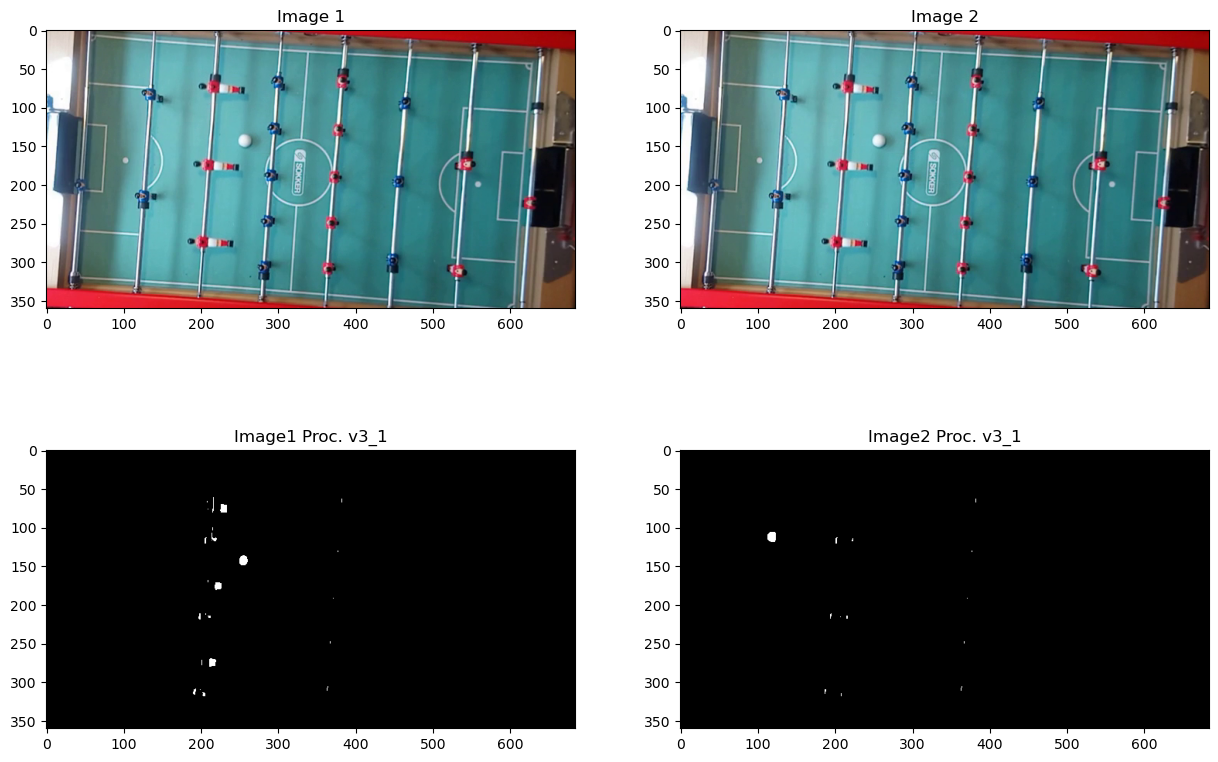

In [83]:
# TODO -- Update the function image_processing_v3_1 by adding an erosion step.

# 1. Importing the morphology module from the library skimage
from skimage import morphology

# 2. Defining the function image_processing_v3_1(...)
def image_processing_v3_1(image, threshold, binary_no_ball=bin_no_ball):

    # 3. Binarizing the image and cleaning it by removing non moving objects and artifacts
    bin_res = image_processing_v2(image, threshold)
    clean = bin_res ^ binary_no_ball

    # 4. Defining a structuring element while choosing its radius
    se_disk = morphology.disk(1)

    # 5. Applying an returning a morphological erosion on the clean image while using the chosen structuring element
    return morphology.erosion(clean, se_disk)

# 6. Testing and showing the results that we get from two color images image1 and image2
%matplotlib inline

image1 = video_frames[50]
image2 = video_frames[100]
no_ball_image = io.imread('images/bg_image.png')

th = 'otsu'
bin_no_ball = image_processing_v2(no_ball_image, th)
ip_v3_1_res1 = image_processing_v3_1(image1, th, bin_no_ball)
ip_v3_1_res2 = image_processing_v3_1(image2, th, bin_no_ball)

fig = plt.figure(figsize=(15,10))
fig.canvas.header_visible = False
plt.subplot(221)
plt.title("Image 1")
plt.imshow(image1, cmap='gray')
plt.subplot(222)
plt.title("Image 2")
plt.imshow(image1, cmap='gray')
plt.subplot(223)
plt.title("Image1 Proc. v3_1")
plt.imshow(ip_v3_1_res1, cmap='gray')
plt.subplot(224)
plt.title("Image2 Proc. v3_1")
plt.imshow(ip_v3_1_res2, cmap='gray')
plt.show()

In [84]:
plt.close('all')

We can see that almost all of the <font size='2'>❌</font> unwanted objects and the artifacts are gone.
Even if the we only managed to keep a tiny part of the <font size='2'>⚽</font> ball segment, this result is still valuable to determine the position of the <font size='2'>⚽</font> ball so allowing us to track it later.

### <font color='dodgerblue'>3.1.2. Apply our image processing function v3_1 on a video</font>

Let's see how is the result of this version v3_1 of our image processing function applied on a video.

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to apply our image processing function v3_1 on each frame of a video.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>✅</font> Loading and getting the video frames and the image <font color='maroon'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
2. <font size='2'>⭕</font> Specifying <font color='red'>'otsu'</font> as threshold
3. <font size='2'>⭕</font> Applying the <font size='3'>⚙</font> [image_processing_v2(...)](functions/image_processing_v2.html) on the image <font color='red'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
4. <font size='2'>⭕</font> Calling the function <font size='3'>⚙</font> [treat_video(...)](functions/treat_video.html) to apply our <font size='3'>⚙</font> <font color='maroon'>image_processing_v3_1(...)</font> function on each frames of <font color='maroon'>video_frames</font>
5. <font size='2'>✅</font> Showing the length of the list containing the binary images result

**<font size='2'>✨</font> <font color='teal'>Functions to consider:</font>**

Here are the simplified prototypes of the functions to consider.

<font size='3'>⚙</font> **[treat_video(video_frames, threshold, our_func)](functions/treat_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - threshold: grayscale value in <font color='maroon'>[0, 255]</font> to use for the binarization process.
    - our_func: a function that will be called for each frame of the video. This function is meant to gather a set of image processing tasks.
- **Return**
    - <font color='maroon'>treated_frames</font>: list of images corresponding to the results

<font size='3'>⚙</font> **[image_processing_v2(image, threshold)](functions/image_processing_v2.html)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

<font size='3'>⚙</font> **image_processing_v3_1(image, threshold, binary_no_ball=bin_no_ball)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
    - binary_no_ball: binary image containing the segments of the non moving
    objects and artifacts. By default, we will use what is in bin_no_ball
    which is a global variable that should contain a result of the call
    of the function image_processing_v2(...) on an image not containing the <font size='2'>⚽</font> ball
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

**<font size='2'>✨</font> <font color='teal'>The output result should be as follows:</font>**

```
165
```

<br/> This result corresponds to the number of treated images.

</div>

In [85]:
# TODO -- Apply a binarization process on each frame of a video

# 1. Loading and getting the video frames and the image which does not have the ball on it
video_frames = get_video_frames_from('videos/video_1_360.mp4')
no_ball_image = io.imread('images/bg_image.png')

# 2. Specifying an 'otsu' as threshold
threshold = 'otsu'

# 3. Applying the image_processing_v2(...) on the image no_ball_image which does not have the ball on it 
bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 4. Calling the function 'treat_video(...)' to apply a binarization image processing v3_1 on each frames of 'video_frames'
video_result_v3_1 = treat_video(video_frames, threshold, image_processing_v3_1)

# 5. Showing the length of the array containing the binary images result
len(video_result_v3_1)

165

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to play the video binarized result v3_1.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- <font color="maroon">video_result_v3_1</font>

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>⭕</font> Choosing an interval (in ms) between each frame display
2. <font size='2'>⭕</font> Displaying the video <font color='maroon'>video_result_v3_1</font> by calling the function [play_video(...)](functions/play_video.html)

**<font size='2'>✨</font> <font color='teal'>Function to call:</font>**

<font size='3'>⚙</font> **[play_video(video_frames, interval, show_axis='on')](functions/play_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - interval: time in millisecond (ms) between two frames.
    - show_axis: <font color="maroon">'on'</font> to show axis values, <font color="maroon">'off'</font> to hide them. Notice that this is not mandatory and it is set to <font color="maroon">'on'</font> by default.

**<font size='2'>✨</font> <font color='teal'>Output result:</font>**

You should see your resulting video displayed.

<font size='5'>⚠</font> Feel free to change the value of the <font color="maroon">interval</font> and experiment the changes and perhaps slow motions. <font size='5'>🐌</font>

</div>

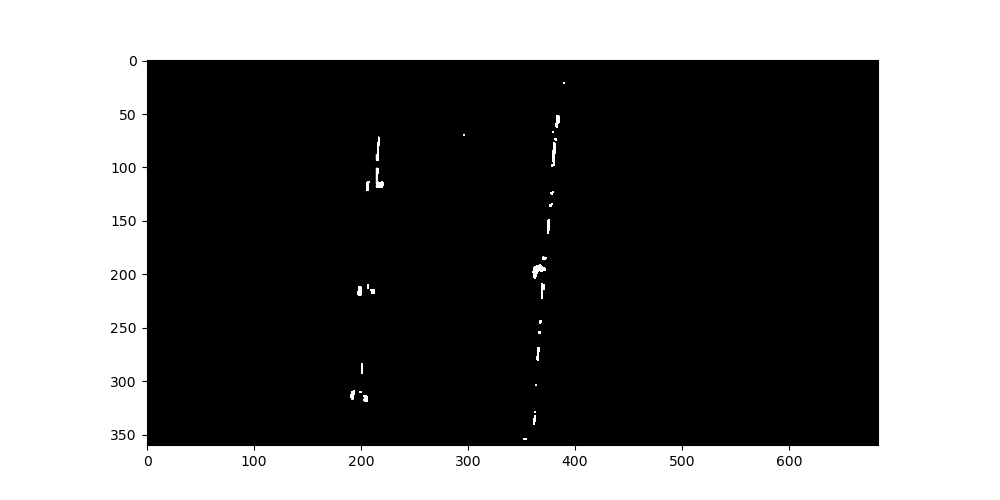

In [89]:
# TODO -- Play the result of the video binarization v3_1

%matplotlib widget

# 1. Choosing an interval (in ms) between each frame display
interval = 5

# 2. Displaying the video 'video_result_v3_1' by calling the function 'play_video(...)'
play_video(video_result_v3_1, interval, show_axis='on')


In [90]:
plt.close('all')

The <font size='2'>⚽</font> ball disapears sometimes but it's ok.
As long as we can track its next nearby position, we can still track it later.

### <font color='dodgerblue'>3.1.3. Time cost of the application of the image processing function v3_1 on a video</font>

What about the time cost?

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to get the time cost of our video treatment.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- <font color="maroon">video_frames</font>

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>⭕</font> Use the magic command [%%timeit](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) to get the time cost of the whole code cell
2. <font size='2'>⭕</font> Specifying <font color='red'>'otsu'</font> as threshold
3. <font size='2'>⭕</font> Applying the <font size='3'>⚙</font> [image_processing_v2(...)](functions/image_processing_v2.html) on the image <font color='red'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
4. <font size='2'>⭕</font> Calling the function <font size='2'>⚙</font> [treat_video(...)](functions/treat_video.html) to apply our <font size='3'>⚙</font> <font color='maroon'>image_processing_v3_1(...)</font> function on each frames of <font color='maroon'>video_frames</font>

**<font size='2'>✨</font> <font color='teal'>Function to call:</font>**

Here is the prototype of the function to use.

<font size='3'>⚙</font> **[treat_video(video_frames, threshold, our_func)](functions/treat_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - threshold: grayscale value in <font color='maroon'>[0, 255]</font> to use for the binarization process.
    - our_func: a function that will be called for each frame of the video. This function is meant to gather a set of image processing tasks.
- **Return**
    - <font color='maroon'>treated_frames</font> a list of images corresponding to the results

<font size='3'>⚙</font> **[image_processing_v2(image, threshold)](functions/image_processing_v2.html)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

**<font size='2'>✨</font> <font color='teal'>The output result should be similar (but not totally) as follows:</font>**

```
21 s ± 4.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

<br/> What can we say about this result?

</div>

In [91]:
%%timeit
# 1. Use the magic command %%timeit to get the time cost of the whole code cell

# 2. Specifying an 'otsu' as threshold
threshold = 'otsu'

# 3. Applying the image_processing_v2(...) on the image no_ball_image which does not have the ball on it
bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 4. Calling the function treat_video(...) to apply our image_processing_v3_1(...) function
# on each frames of video_frames
video_result = treat_video(video_frames, threshold, image_processing_v3_1)

4.64 s ± 7.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The time cost is getting more and more expensive.

## <font color='dodgerblue'>3.2. image_processing_v3_2(...): erosion + reconstruction</font>

For the second update version v3_2 of our image processing function we will add to the version v3_1 a morphological reconstruction step in order to get a result where the segment of the <font size='2'>⚽</font> ball would not be that small.

### <font color='dodgerblue'>3.2.1. Implementing the image processing function v3_2</font>

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow inorder to update the function image_processing_v3_2 by adding an erosion step.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. Importing the morphology module from the library skimage
2. Defining the function image_processing_v3_2(...)
3. Binarizing the image and cleaning it by removing non moving objects and artifacts (this part was already in the initial version v3)
4. Doing an erosion on the clean result (this part is in the first updated version v3_1)
5. Applying morphological reconstruction on the clean image by using the erosion result as a seed
6. Testing and showing the results that we get from two color images image1 and image2

**<font size='2'>✨</font> <font color='teal'>Functions to use:</font>**

- [morphology.reconstruction(reconstruction(seed, image))](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.reconstruction)
    
**<font size='2'>✨</font> <font color='teal'>The output result should be as follows.</font>**

<img src='figs/image_processing_v3_2_res.png'/>

</div>

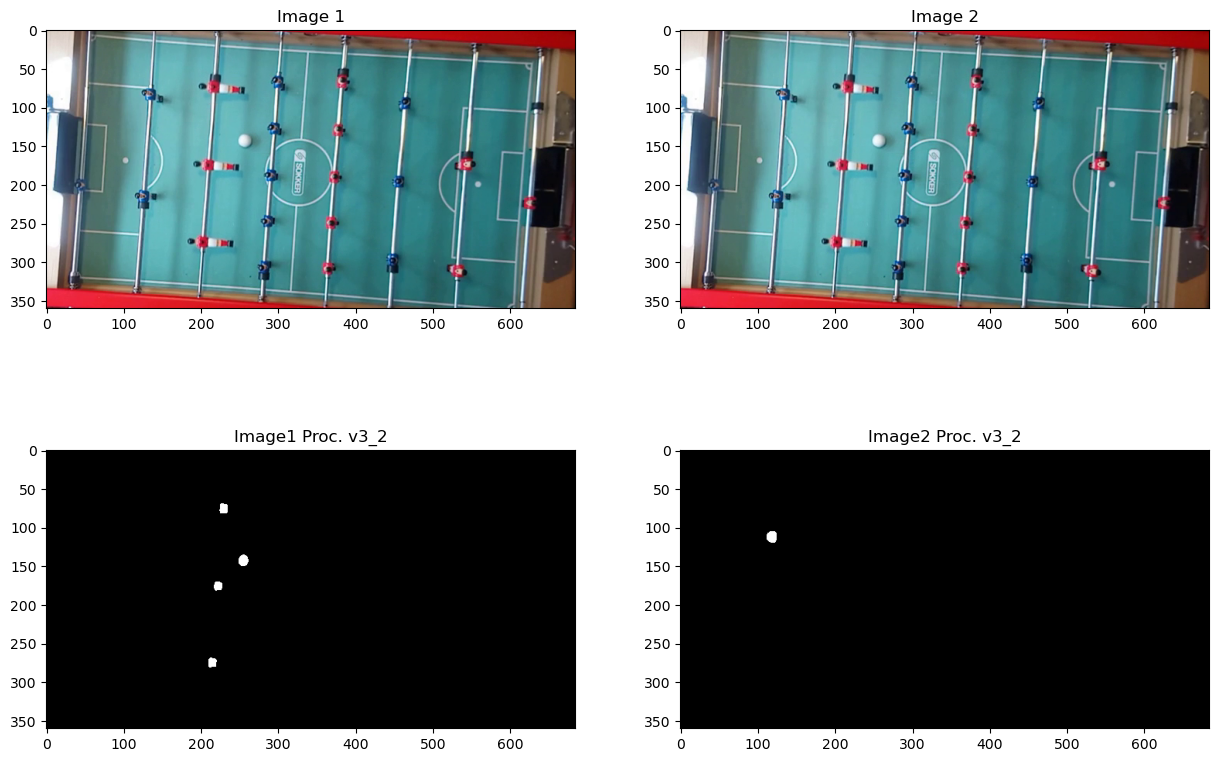

In [98]:
# TODO -- Update the function image_processing_v3_2 by adding an erosion step.

# 1. Importing the morphology module from the library skimage
from skimage import morphology

# 2. Defining the function image_processing_v3_2(...)
def image_processing_v3_2(image, threshold, binary_no_ball=bin_no_ball):

    # 3. Binarizing the image and cleaning it by removing non moving objects and artifacts
    # This part was already in the initial version v3
    bin_res = image_processing_v2(image, threshold)
    clean = bin_res ^ binary_no_ball

    # 4. Doing an erosion on the clean result
    # This part is in the first updated version v3_1
    se_disk = morphology.disk(4)
    erosion = morphology.erosion(clean, se_disk)

    # 5. Applying morphological reconstruction on the clean image by using the erosion result as a seed
    return morphology.reconstruction(seed=erosion, mask=clean)

# 6. Testing and showing the results that we get from two color images image1 and image2
%matplotlib inline

image1 = video_frames[50]
image2 = video_frames[100]
no_ball_image = io.imread('images/bg_image.png')

th = 'otsu'
bin_no_ball = image_processing_v2(no_ball_image, th)
ip_v3_2_res1 = image_processing_v3_2(image1, th, bin_no_ball)
ip_v3_2_res2 = image_processing_v3_2(image2, th, bin_no_ball)

fig = plt.figure(figsize=(15,10))
fig.canvas.header_visible = False
plt.subplot(221)
plt.title("Image 1")
plt.imshow(image1, cmap='gray')
plt.subplot(222)
plt.title("Image 2")
plt.imshow(image1, cmap='gray')
plt.subplot(223)
plt.title("Image1 Proc. v3_2")
plt.imshow(ip_v3_2_res1, cmap='gray')
plt.subplot(224)
plt.title("Image2 Proc. v3_2")
plt.imshow(ip_v3_2_res2, cmap='gray')
plt.show()

In [99]:
plt.close('all')

The reconstruction step is bringing back the form of the <font size='2'>⚽</font> ball segment while the <font size='2'>❌</font> unwanted objects and artifacts remain removed.

### <font color='dodgerblue'>3.2.2. Apply our image processing function v3_2 on a video</font>

Let's see how is the result of this version v3_2 of our image processing function applied on a video.

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to apply our image processing function v3_2 on each frame of a video.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>✅</font> Loading and getting the video frames and the image <font color='maroon'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
2. <font size='2'>⭕</font> Specifying <font color='red'>'otsu'</font> as threshold
3. <font size='2'>⭕</font> Applying the <font size='3'>⚙</font> [image_processing_v2(...)](functions/image_processing_v2.html) on the image <font color='red'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
4. <font size='2'>⭕</font> Calling the function <font size='3'>⚙</font> [treat_video(...)](functions/treat_video.html) to apply our <font size='3'>⚙</font> <font color='maroon'>image_processing_v3_2(...)</font> function on each frames of <font color='maroon'>video_frames</font>
5. <font size='2'>✅</font> Showing the length of the list containing the binary images result

**<font size='2'>✨</font> <font color='teal'>Functions to consider:</font>**

Here are the simplified prototypes of the functions to consider.

<font size='3'>⚙</font> **[treat_video(video_frames, threshold, our_func)](functions/treat_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - threshold: grayscale value in <font color='maroon'>[0, 255]</font> to use for the binarization process.
    - our_func: a function that will be called for each frame of the video. This function is meant to gather a set of image processing tasks.
- **Return**
    - <font color='maroon'>treated_frames</font>: list of images corresponding to the results

<font size='3'>⚙</font> **[image_processing_v2(image, threshold)](functions/image_processing_v2.html)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

<font size='3'>⚙</font> **image_processing_v3_2(image, threshold, binary_no_ball=bin_no_ball)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
    - binary_no_ball: binary image containing the segments of the non moving
    objects and artifacts. By default, we will use what is in bin_no_ball
    which is a global variable that should contain a result of the call
    of the function image_processing_v2(...) on an image not containing the <font size='2'>⚽</font> ball
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

**<font size='2'>✨</font> <font color='teal'>The output result should be as follows:</font>**

```
165
```

<br/> This result corresponds to the number of treated images.

</div>

In [100]:
# TODO -- Apply a binarization process on each frame of a video

# 1. Loading and getting the video frames and the image which does not have the ball on it
video_frames = get_video_frames_from('videos/video_1_360.mp4')
no_ball_image = io.imread('images/bg_image.png')

# 2. Specifying an 'otsu' as threshold
threshold = 'otsu'

# 3. Applying the image_processing_v2(...) on the image no_ball_image which does not have the ball on it 
bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 4. Calling the function 'treat_video(...)' to apply a binarization image processing v3_2 on each frames of 'video_frames'
video_result_v3_2 = treat_video(video_frames, threshold, image_processing_v3_2)

# 5. Showing the length of the array containing the binary images result
len(video_result_v3_2)

165

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to play the video binarized result v3_2.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- <font color="maroon">video_result_v3_2</font>

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>⭕</font> Choosing an interval (in ms) between each frame display
2. <font size='2'>⭕</font> Displaying the video <font color='maroon'>video_result_v3_2</font> by calling the function [play_video(...)](functions/play_video.html)

**<font size='2'>✨</font> <font color='teal'>Function to call:</font>**

<font size='3'>⚙</font> **[play_video(video_frames, interval, show_axis='on')](functions/play_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - interval: time in millisecond (ms) between two frames.
    - show_axis: <font color="maroon">'on'</font> to show axis values, <font color="maroon">'off'</font> to hide them. Notice that this is not mandatory and it is set to <font color="maroon">'on'</font> by default.

**<font size='2'>✨</font> <font color='teal'>Output result:</font>**

You should see your resulting video displayed.

<font size='5'>⚠</font> Feel free to change the value of the <font color="maroon">interval</font> and experiment the changes and perhaps slow motions. <font size='5'>🐌</font>

</div>

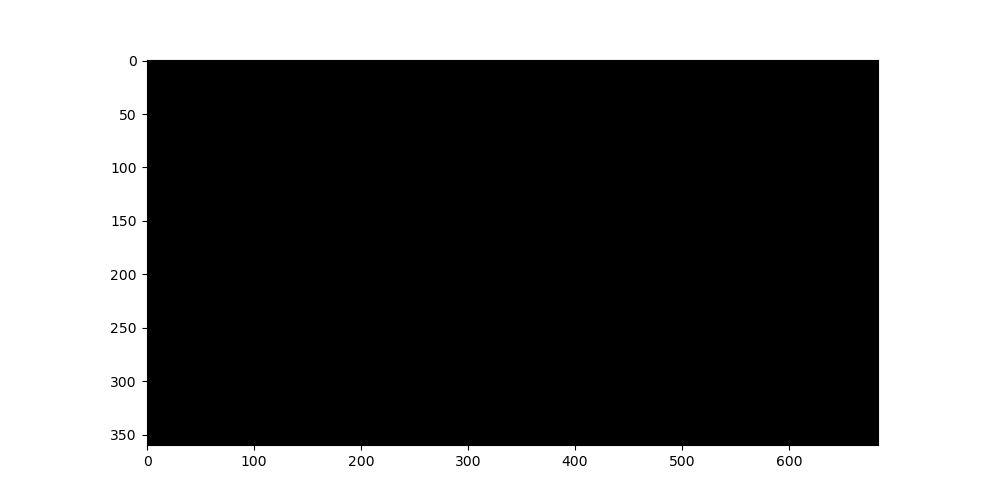

In [103]:
# TODO -- Play the result of the video binarization v3_2

%matplotlib widget

# 1. Choosing an interval (in ms) between each frame display
interval = 5

# 2. Displaying the video 'video_result_v3_2' by calling the function 'play_video(...)'
play_video(video_result_v3_2, interval, show_axis='on')

In [104]:
plt.close('all')

The result is interesting but what about the time cost?

### <font color='dodgerblue'>3.2.3. Time cost of the application of the image processing function v3_2 on a video</font>

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to get the time cost of our video treatment.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- <font color="maroon">video_frames</font>

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>⭕</font> Use the magic command [%%timeit](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) to get the time cost of the whole code cell
2. <font size='2'>⭕</font> Specifying <font color='red'>'otsu'</font> as threshold
3. <font size='2'>⭕</font> Applying the <font size='3'>⚙</font> [image_processing_v2(...)](functions/image_processing_v2.html) on the image <font color='red'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
4. <font size='2'>⭕</font> Calling the function <font size='2'>⚙</font> [treat_video(...)](functions/treat_video.html) to apply our <font size='3'>⚙</font> <font color='maroon'>image_processing_v3_2(...)</font> function on each frames of <font color='maroon'>video_frames</font>

**<font size='2'>✨</font> <font color='teal'>Function to call:</font>**

Here is the prototype of the function to use.

<font size='3'>⚙</font> **[treat_video(video_frames, threshold, our_func)](functions/treat_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - threshold: grayscale value in <font color='maroon'>[0, 255]</font> to use for the binarization process.
    - our_func: a function that will be called for each frame of the video. This function is meant to gather a set of image processing tasks.
- **Return**
    - <font color='maroon'>treated_frames</font> a list of images corresponding to the results

<font size='3'>⚙</font> **[image_processing_v2(image, threshold)](functions/image_processing_v2.html)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

**<font size='2'>✨</font> <font color='teal'>The output result should be similar (but not totally) as follows:</font>**

```
32.8 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

<br/> What can we say about this result?

</div>

In [105]:
%%timeit
# 1. Use the magic command %%timeit to get the time cost of the whole code cell

# 2. Specifying an 'otsu' as threshold
threshold = 'otsu'

# 3. Applying the image_processing_v2(...) on the image no_ball_image which does not have the ball on it
bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 4. Calling the function treat_video(...) to apply our image_processing_v3_2(...) function
# on each frames of video_frames
video_result = treat_video(video_frames, threshold, image_processing_v3_2)

11.4 s ± 257 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The time cost is getting more and more and more expensive.

## <font color='dodgerblue'>3.3. image_processing_v3_3(...): residue of the white top-hat</font>

We could try to reach a more clean result by applying more morphological operations combination.

### <font color='dodgerblue'>3.3.1. Implementing the image processing function v3_3</font>

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow inorder to update the function image_processing_v3_3 by doing a top-hat and removing it from the clean binary result.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. Importing the morphology module from the library skimage
2. Defining the function image_processing_v3_3(...)
3. Binarizing the image and cleaning it by removing non moving objects and artifacts (this part was already in the initial version v3)
4. Choosing a disk of radius 6 as structuring element
5. Applying a top-hat on the eroded binary result
6. Removing the result of the top-hat from the clean image and returning the result
7. Testing and showing the results that we get from two color images image1 and image2

**<font size='2'>✨</font> <font color='teal'>Functions to use:</font>**

- [morphology.reconstruction(reconstruction(seed, image))](https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.reconstruction)

**<font size='2'>✨</font> <font color='teal'>The output result should be as follows.</font>**

<img src='figs/image_processing_v3_3_res.png'/>

</div>

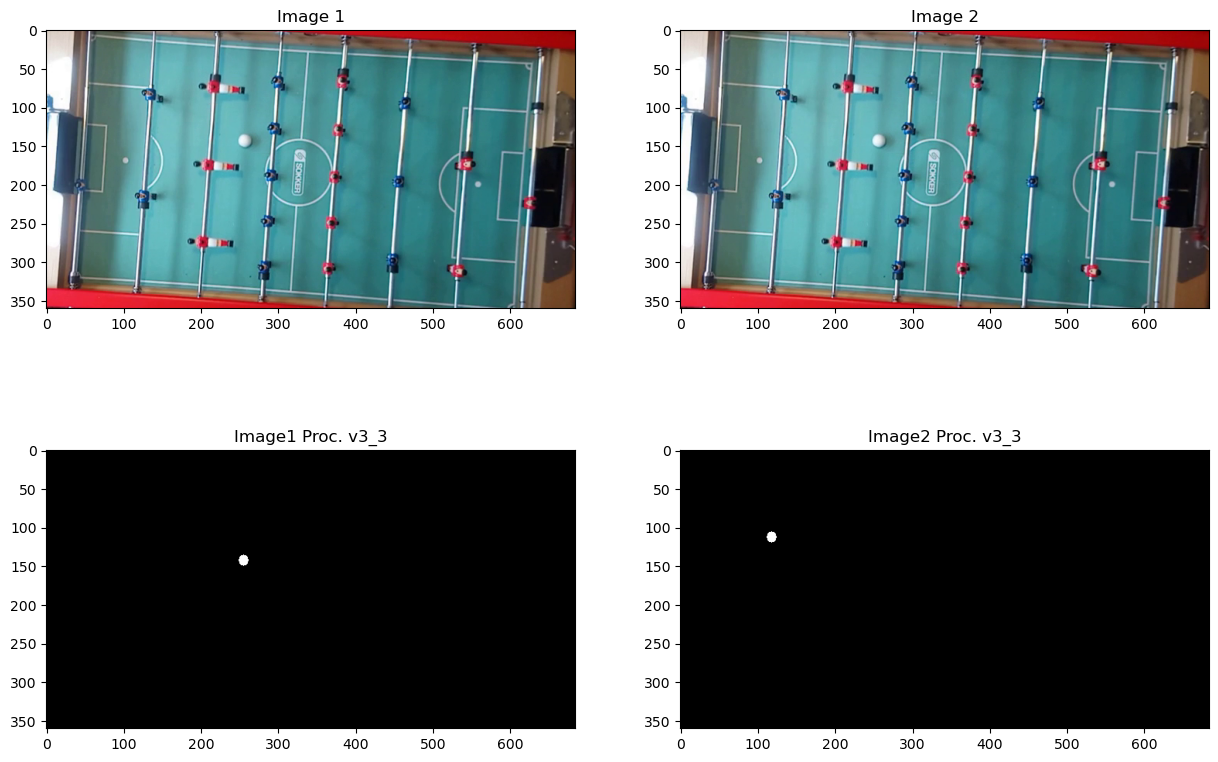

In [113]:
# TODO -- Update the function image_processing_v3_3 by doing a top-hat and removing it from the clean binary result.

# 1. Importing the morphology module from the library skimage
from skimage import morphology

# 2. Defining the function image_processing_v3_3(...)
def image_processing_v3_3(image, threshold, binary_no_ball=bin_no_ball):

    # 3. Binarizing the image and cleaning it by removing non moving objects and artifacts
    # This part was already in the initial version v3
    bin_res = image_processing_v2(image, threshold)
    clean = bin_res ^ binary_no_ball

    # 4. Choosing a disk of radius 6 as structuring element
    se_disk = morphology.disk(6)
                              
    # 5. Applying a top-hat on the eroded binary result by considering the se_disk structuring element
    white_th = morphology.white_tophat(clean, se_disk)

    # 6. Removing the result of the top-hat from the clean image and returning the result
    return clean ^ white_th

# 7. Testing and showing the results that we get from two color images image1 and image2
%matplotlib inline

image1 = video_frames[50]
image2 = video_frames[100]
no_ball_image = io.imread('images/bg_image.png')

th = 'otsu'
bin_no_ball = image_processing_v2(no_ball_image, th)
ip_v3_3_res1 = image_processing_v3_3(image1, th, bin_no_ball)
ip_v3_3_res2 = image_processing_v3_3(image2, th, bin_no_ball)

fig = plt.figure(figsize=(15,10))
fig.canvas.header_visible = False
plt.subplot(221)
plt.title("Image 1")
plt.imshow(image1, cmap='gray')
plt.subplot(222)
plt.title("Image 2")
plt.imshow(image1, cmap='gray')
plt.subplot(223)
plt.title("Image1 Proc. v3_3")
plt.imshow(ip_v3_3_res1, cmap='gray')
plt.subplot(224)
plt.title("Image2 Proc. v3_3")
plt.imshow(ip_v3_3_res2, cmap='gray')
# plt.savefig('figs/image_processing_v3_3_res.png', bbox_inches='tight')
plt.show()

In [115]:
plt.close('all')

Those results seem to be close enough to the ideal segmentation results that we wished.

### <font color='dodgerblue'>3.3.2 Apply our image processing function v3_3 on a video</font>

Let's see how is the result of this version v3_3 of our image processing function applied on a video.

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to apply our image processing function v3_3 on each frame of a video.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>✅</font> Loading and getting the video frames and the image <font color='maroon'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
2. <font size='2'>⭕</font> Specifying <font color='red'>'otsu'</font> as threshold
3. <font size='2'>⭕</font> Applying the <font size='3'>⚙</font> [image_processing_v2(...)](functions/image_processing_v2.html) on the image <font color='red'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
4. <font size='2'>⭕</font> Calling the function <font size='3'>⚙</font> [treat_video(...)](functions/treat_video.html) to apply our <font size='3'>⚙</font> <font color='maroon'>image_processing_v3_3(...)</font> function on each frames of <font color='maroon'>video_frames</font>
5. <font size='2'>✅</font> Showing the length of the list containing the binary images result

**<font size='2'>✨</font> <font color='teal'>Functions to consider:</font>**

Here are the simplified prototypes of the functions to consider.

<font size='3'>⚙</font> **[treat_video(video_frames, threshold, our_func)](functions/treat_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - threshold: grayscale value in <font color='maroon'>[0, 255]</font> to use for the binarization process.
    - our_func: a function that will be called for each frame of the video. This function is meant to gather a set of image processing tasks.
- **Return**
    - <font color='maroon'>treated_frames</font>: list of images corresponding to the results

<font size='3'>⚙</font> **[image_processing_v2(image, threshold)](functions/image_processing_v2.html)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

<font size='3'>⚙</font> **image_processing_v3_2(image, threshold, binary_no_ball=bin_no_ball)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
    - binary_no_ball: binary image containing the segments of the non moving
    objects and artifacts. By default, we will use what is in bin_no_ball
    which is a global variable that should contain a result of the call
    of the function image_processing_v2(...) on an image not containing the <font size='2'>⚽</font> ball
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

**<font size='2'>✨</font> <font color='teal'>The output result should be as follows:</font>**

```
165
```

<br/> This result corresponds to the number of treated images.

</div>

In [116]:
# TODO -- Apply a binarization process on each frame of a video

# 1. Loading and getting the video frames and the image which does not have the ball on it
video_frames = get_video_frames_from('videos/video_1_360.mp4')
no_ball_image = io.imread('images/bg_image.png')

# 2. Specifying an 'otsu' as threshold
threshold = 'otsu'

# 3. Applying the image_processing_v2(...) on the image no_ball_image which does not have the ball on it 
bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 4. Calling the function 'treat_video(...)' to apply a binarization image processing v3_3 on each frames of 'video_frames'
video_result_v3_3 = treat_video(video_frames, threshold, image_processing_v3_3)

# 5. Showing the length of the array containing the binary images result
len(video_result_v3_3)

165

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to play the video binarized result v3_3.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- <font color="maroon">video_result_v3_3</font>

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>⭕</font> Choosing an interval (in ms) between each frame display
2. <font size='2'>⭕</font> Displaying the video <font color='maroon'>video_result_v3_3</font> by calling the function [play_video(...)](functions/play_video.html)

**<font size='2'>✨</font> <font color='teal'>Function to call:</font>**

<font size='3'>⚙</font> **[play_video(video_frames, interval, show_axis='on')](functions/play_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - interval: time in millisecond (ms) between two frames.
    - show_axis: <font color="maroon">'on'</font> to show axis values, <font color="maroon">'off'</font> to hide them. Notice that this is not mandatory and it is set to <font color="maroon">'on'</font> by default.

**<font size='2'>✨</font> <font color='teal'>Output result:</font>**

You should see your resulting video displayed.

<font size='5'>⚠</font> Feel free to change the value of the <font color="maroon">interval</font> and experiment the changes and perhaps slow motions. <font size='5'>🐌</font>

</div>

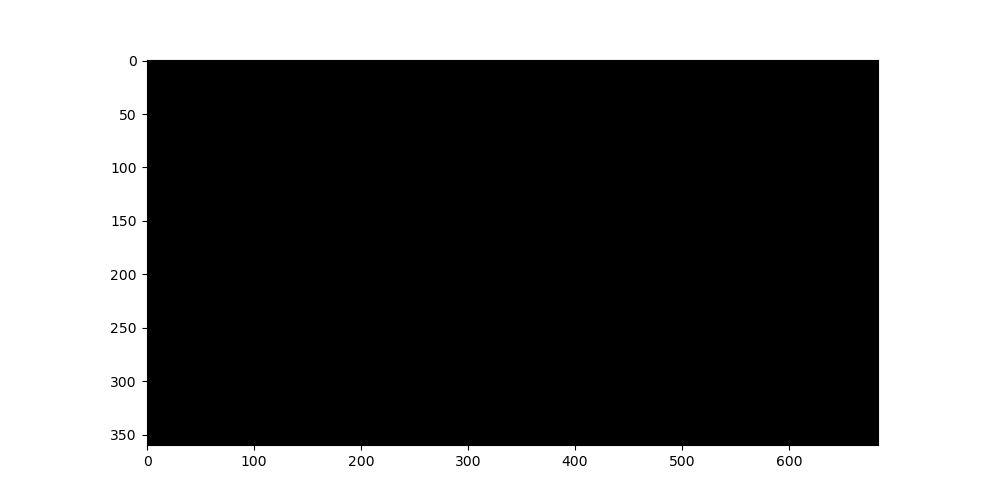

In [122]:
# TODO -- Play the result of the video binarization v3_3

%matplotlib widget

# 1. Choosing an interval (in ms) between each frame display
interval = 5

# 2. Displaying the video 'video_result_v3_3' by calling the function 'play_video(...)'
play_video(video_result_v3_3, interval, show_axis='on')


In [120]:
plt.close('all')

The quality of the segmentation of some frames frame are really great but we can also see that many frames cannot deliver a result.

### <font color='dodgerblue'>3.3.3. Time cost of the application of the image processing function v3_3 on a video</font>

What about the time cost?

<div style="padding : 20px; background-color:#E6E6FA;">

##### **<font color="#1E90FF">TODO <font size='5'>🔻</font> -- Fill the cell code bellow in order to get the time cost of our video treatment.</font> <font size='5'>🔨</font>**

**<font size='2'>✨</font> <font color='teal'>Variable ready to use:</font>**

- <font color="maroon">video_frames</font>

**<font size='2'>✨</font> <font color='teal'>The steps to follow are:</font>**

1. <font size='2'>⭕</font> Use the magic command [%%timeit](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit) to get the time cost of the whole code cell
2. <font size='2'>⭕</font> Specifying <font color='red'>'otsu'</font> as threshold
3. <font size='2'>⭕</font> Applying the <font size='3'>⚙</font> [image_processing_v2(...)](functions/image_processing_v2.html) on the image <font color='red'>no_ball_image</font> which does not have the <font size='2'>⚽</font> ball on it
4. <font size='2'>⭕</font> Calling the function <font size='2'>⚙</font> [treat_video(...)](functions/treat_video.html) to apply our <font size='3'>⚙</font> <font color='maroon'>image_processing_v3_3(...)</font> function on each frames of <font color='maroon'>video_frames</font>

**<font size='2'>✨</font> <font color='teal'>Function to call:</font>**

Here is the prototype of the function to use.

<font size='3'>⚙</font> **[treat_video(video_frames, threshold, our_func)](functions/treat_video.html)**
- **Parameters**
    - video_frames: sequence of frames to read. Each frame is an image so this is a <font color="maroon">list</font> of images.
    - threshold: grayscale value in <font color='maroon'>[0, 255]</font> to use for the binarization process.
    - our_func: a function that will be called for each frame of the video. This function is meant to gather a set of image processing tasks.
- **Return**
    - <font color='maroon'>treated_frames</font> a list of images corresponding to the results

<font size='3'>⚙</font> **[image_processing_v2(image, threshold)](functions/image_processing_v2.html)**
- **Parameters**
    - image: rgb color image to treat
    - threshold: <font color="maroon">uint8</font> grayscale value used for the binarisation, the value should be in <font color='maroon'>[0, 255]</font> or <font color='red'>'Otsu'</font> by default
- **Return**
    - binary_image: <font color="maroon">bool</font> [ndarray](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) simplified binary image

**<font size='2'>✨</font> <font color='teal'>The output result should be similar (but not totally) as follows:</font>**

```
28.1 s ± 238 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
```

<br/> What can we say about this result?

</div>

In [121]:
%%timeit
# 1. Use the magic command %%timeit to get the time cost of the whole code cell

# 2. Specifying an 'otsu' as threshold
threshold = 'otsu'

# 3. Applying the image_processing_v2(...) on the image no_ball_image which does not have the ball on it
bin_no_ball = image_processing_v2(no_ball_image, threshold)

# 4. Calling the function treat_video(...) to apply our image_processing_v3_3(...) function
# on each frames of video_frames
video_result_v3_3 = treat_video(video_frames, threshold, image_processing_v3_3)

14.5 s ± 304 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The time cost is getting more and more and more and more and more expensive.

## <font color='dodgerblue'>3.4. Implemented different versions</font>

<table>
    <tr style="background-color:gray; color:white;">
        <td><b>Result</b></td>
        <td><b>Versions</b></td>
    </tr>
    <tr style="background-color:white;">
        <td>
            <img src='videos/result_video_processing_v3.webp' width=800/>
        </td>
        <td>
            <font size='4'>✅</font> <b>image_processing_<span style='color: white; background-color: #f1c40f; padding: 2px;'>v3</b></span><br/><br/>
            <font color="dodgerblue"><b>Preprocessing</b></font><br/>
                - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> RGB image to grayscale image transformation<br/>
                - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> Grayscale image to ubyte image so we get values in <font color='maroon'>[0, 255]</font><br/>
                - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Difference of gaussians to get rid of shadows<br/><br/>
            <font color="dodgerblue"><b>Segmentation<b></font><br/>
                - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Binarization using an otsu automated threshold<br/>
                - <span style='color: white; background-color:   #f1c40f; padding: 2px;'><b>v3</b></span> Non moving object removing<br/><br/>
            <b>Time cost:</b><br>
            9.51 s ± 637 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        </td>
    </tr>
    <tr style="background-color:white;">
        <td>
            <img src='videos/result_video_processing_v3_1.webp' width=800/>
        </td>
        <td>
            <font size='4'>✅</font> <b>image_processing_<span style='color: white; background-color: #f1c40f; padding: 2px;'>v3_1</b></span><br/><br/>
            <font color="dodgerblue"><b>Preprocessing</b></font><br/>
                - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> RGB image to grayscale image transformation<br/>
                - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> Grayscale image to ubyte image so we get values in <font color='maroon'>[0, 255]</font><br/>
                - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Difference of gaussians to get rid of shadows<br/><br/>
            <font color="dodgerblue"><b>Segmentation<b></font><br/>
                - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Binarization using an otsu automated threshold<br/>
                - <span style='color: white; background-color:   #f1c40f; padding: 2px;'><b>v3</b></span> Non moving object removing<br/><br/>
                - <span style='color: white; background-color:   #f1c40f; padding: 2px;'><b>v3_1</b></span> Erosion of the cleaned binary result<br/><br/>
            <b>Time cost:</b><br>
            21 s ± 4.96 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
        </td>
    </tr>    
    <tr style="background-color:white;">
        <td>
            <img src='videos/result_video_processing_v3_2.webp' width=800/>
        </td>
        <td>
            <font size='4'>✅</font> <b>image_processing_<span style='color: white; background-color: #f1c40f; padding: 2px;'>v3_2</b></span><br/><br/>
            <font color="dodgerblue"><b>Preprocessing</b></font><br/>
                - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> RGB image to grayscale image transformation<br/>
                - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> Grayscale image to ubyte image so we get values in <font color='maroon'>[0, 255]</font><br/>
                - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Difference of gaussians to get rid of shadows<br/><br/>
            <font color="dodgerblue"><b>Segmentation<b></font><br/>
                - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Binarization using an otsu automated threshold<br/>
                - <span style='color: white; background-color:   #f1c40f; padding: 2px;'><b>v3</b></span> Non moving object removing<br/><br/>
                - <span style='color: white; background-color:   #f1c40f; padding: 2px;'><b>v3_1</b></span> Erosion of the cleaned binary result<br/><br/>
                - <span style='color: white; background-color:   #f1c40f; padding: 2px;'><b>v3_2</b></span> Reconstruction of the eroded result<br/><br/>
            <b>Time cost:</b><br>
            32.8 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        </td>
    </tr>
    <tr style="background-color:white;">
        <td>
            <img src='videos/result_video_processing_v3_3.webp' width=800/>
        </td>
        <td>
            <font size='4'>✅</font> <b>image_processing_<span style='color: white; background-color: #f1c40f; padding: 2px;'>v3_3</b></span><br/><br/>
            <font color="dodgerblue"><b>Preprocessing</b></font><br/>
                - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> RGB image to grayscale image transformation<br/>
                - <span style='color: white; background-color:  #3498db; padding: 2px;'><b>v1</b></span> Grayscale image to ubyte image so we get values in <font color='maroon'>[0, 255]</font><br/>
                - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Difference of gaussians to get rid of shadows<br/><br/>
            <font color="dodgerblue"><b>Segmentation<b></font><br/>
                - <span style='color: white; background-color:   #f1948a; padding: 2px;'><b>v2</b></span> Binarization using an otsu automated threshold<br/>
                - <span style='color: white; background-color:   #f1c40f; padding: 2px;'><b>v3</b></span> Non moving object removing<br/><br/>
                - <span style='color: white; background-color:   #f1c40f; padding: 2px;'><b>v3_3</b></span> Residual of the top-hat of the cleaned binary result<br/><br/>
            <b>Time cost:</b><br>
            28.1 s ± 238 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        </td>
    </tr>
</table>

We have to make a balance between the performance and the time cost.
As the time cost matter to us, we will use the image_processing_v3_1(...) for our next steps since it will help us to track the ball's position on our video with an acceptable time cost.

<font color="purple">**Félicitations**</font> <font size='5'>❗🎉</font> 

You reached the end of this notebook and implemented the image processing pipeline versions above. <font size='5'>🏅</font>

### <font color='dodgerblue'>Still have time?</font>

- Try various combinations of morphological operations to get other results.
- Try to segment the goal cages by using what we have learned for a possible goal counting